# Synthetic SWRart Dataset

Artificial SWRart dataset that mimicks biological Sharp Wave Ripples

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# imports
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from swrart import generate_simulated_swr, generate_three_phase_swr, plot_swr, generate_swr_dataset, plot_random_swrs
from utils import prepare_data, add_label_noise, prepare_ssl_data
from models.cnn import CNN1D
from models.encoder import Encoder, TC
from training import train_model, plot_training_history, train_self_supervised, relabel_dataset

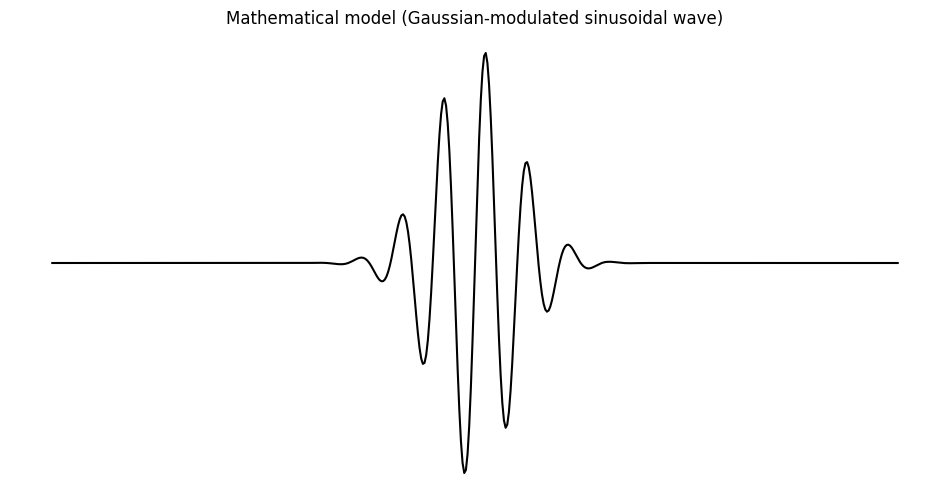

In [18]:
t = np.linspace(-1, 1, 512)  # Time array
swr = generate_simulated_swr(t)
plot_swr(swr, "Mathematical model (Gaussian-modulated sinusoidal wave)")

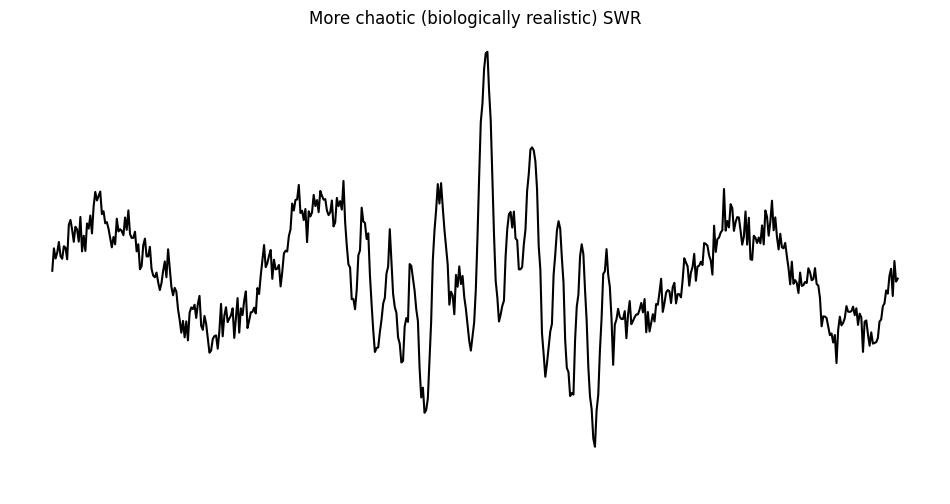

In [43]:
t = np.linspace(-1, 1, 512)  # Time array
swr = generate_three_phase_swr(t)
plot_swr(swr, "More chaotic (biologically realistic) SWR")

## Generate the SWRart Dataset

In [50]:
# Generate 20,000 SWRs for "before learning" and "after learning"
n_samples = 10000
before_learning_dataset = generate_swr_dataset(n_samples, t, 'before')
after_learning_dataset = generate_swr_dataset(n_samples, t, 'after')

# Add label column (0 for before, 1 for after)
before_learning_dataset['label'] = 0
after_learning_dataset['label'] = 1

# Save the datasets to CSV files
before_learning_csv_path = '../data/swrart/before_learning_swr_dataset.csv'
after_learning_csv_path = '../data/swrart/after_learning_swr_dataset.csv'
before_learning_dataset.to_csv(before_learning_csv_path, index=False)
after_learning_dataset.to_csv(after_learning_csv_path, index=False)

In [2]:
# Read the SWRs from CSV files
before_learning_dataset = pd.read_csv('../data/swrart/before_learning_swr_dataset.csv')
after_learning_dataset = pd.read_csv('../data/swrart/after_learning_swr_dataset.csv')

In [3]:
before_learning_dataset

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
0,-0.221663,-0.257189,-0.226410,-0.200494,-0.206597,-0.264861,-0.256260,-0.290253,-0.341663,-0.333906,...,-0.187295,-0.193329,-0.157222,-0.171323,-0.150266,-0.158458,-0.142318,-0.154892,-0.172152,0
1,0.221253,0.169868,0.107371,0.083876,0.094189,0.110245,0.110063,0.087971,0.131723,0.137032,...,0.182281,0.152978,0.120832,0.102274,0.148275,0.150225,0.201356,0.229329,0.262688,0
2,-0.254372,-0.224552,-0.250716,-0.172196,-0.151516,-0.164874,-0.127033,-0.149887,-0.155268,-0.145767,...,-0.229302,-0.213873,-0.194484,-0.189477,-0.202056,-0.216224,-0.199270,-0.212966,-0.210031,0
3,0.340715,0.309102,0.261813,0.264695,0.208874,0.210899,0.206445,0.222443,0.201492,0.193159,...,0.196245,0.207222,0.182171,0.159018,0.141662,0.161731,0.178677,0.197675,0.184468,0
4,-0.390611,-0.358315,-0.344031,-0.344332,-0.275773,-0.336006,-0.336491,-0.314758,-0.283268,-0.206212,...,-0.402762,-0.358529,-0.380538,-0.366474,-0.355857,-0.335963,-0.313833,-0.275450,-0.258864,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.122058,0.109298,0.076354,0.050698,0.084838,0.092812,0.123405,0.106301,0.096997,0.098469,...,0.172008,0.184803,0.159735,0.177877,0.133570,0.142844,0.105211,0.095495,0.031526,0
9996,0.010364,-0.032207,-0.001085,0.003974,0.023952,0.018738,0.024332,0.040726,-0.009320,-0.018023,...,-0.004789,-0.030345,0.010793,0.012407,0.019628,0.062196,0.098396,0.083788,0.041815,0
9997,-0.020842,-0.039474,-0.050947,-0.039333,-0.066504,-0.078644,-0.048126,-0.035101,-0.059684,-0.109988,...,0.087290,0.148040,0.127090,0.093011,0.087707,0.038776,0.019632,-0.055363,-0.082785,0
9998,0.099881,0.115284,0.150805,0.180223,0.207389,0.224351,0.255657,0.231835,0.270332,0.237377,...,0.071904,0.092541,-0.022657,-0.009089,-0.051038,0.004464,0.002375,-0.004753,0.041004,0


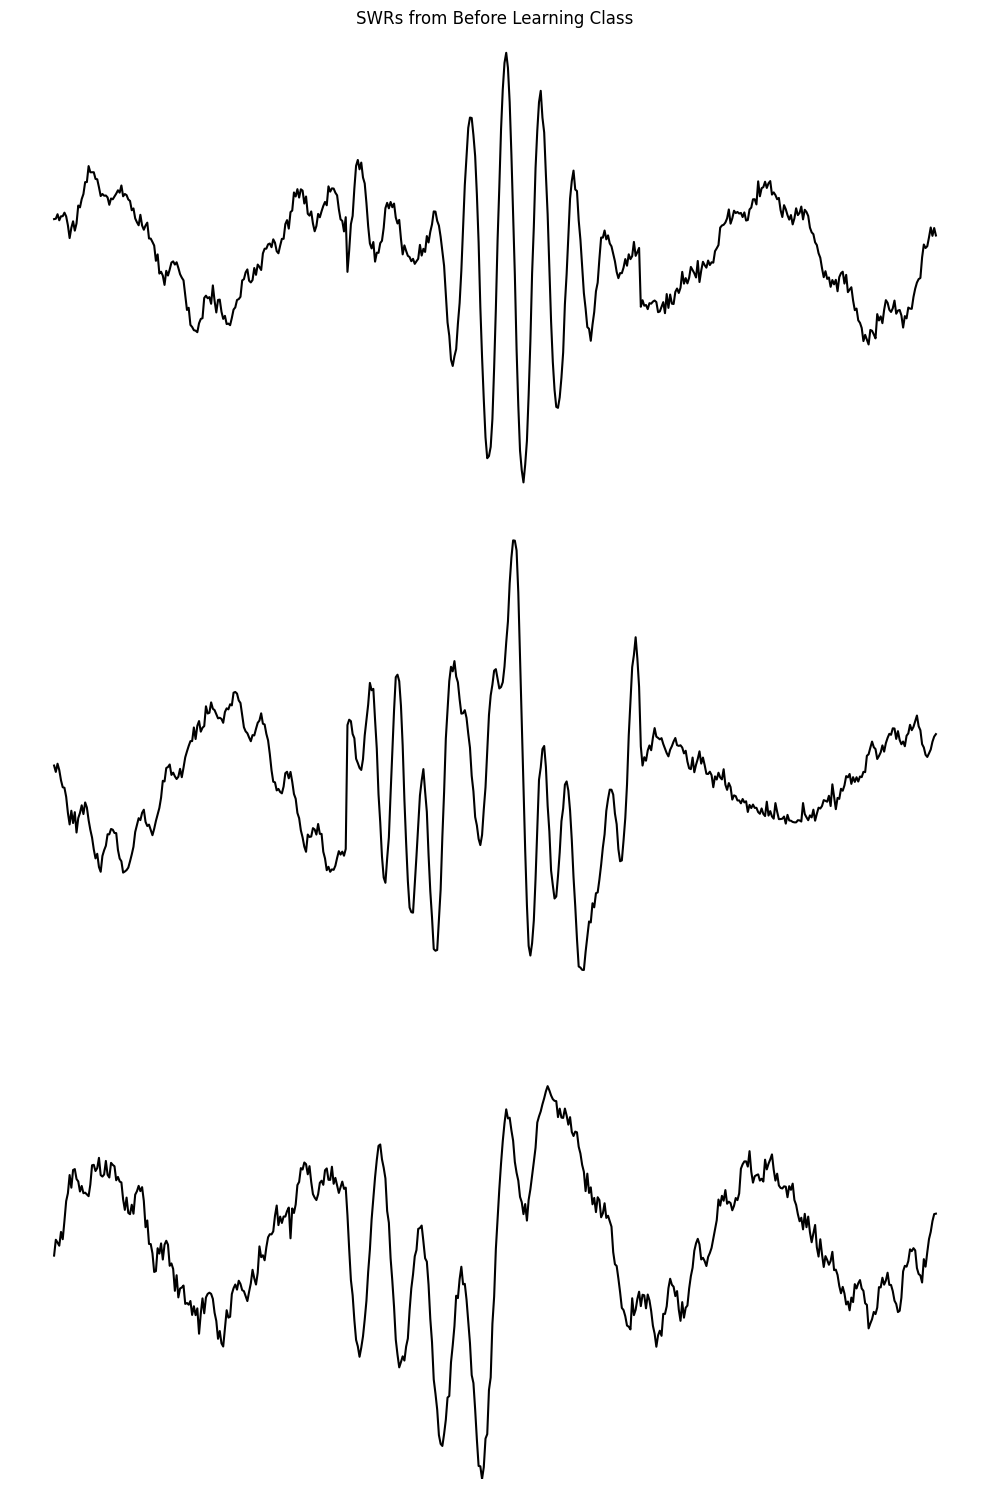

In [59]:
plot_random_swrs(before_learning_dataset, n_samples=3, title="SWRs from Before Learning Class")

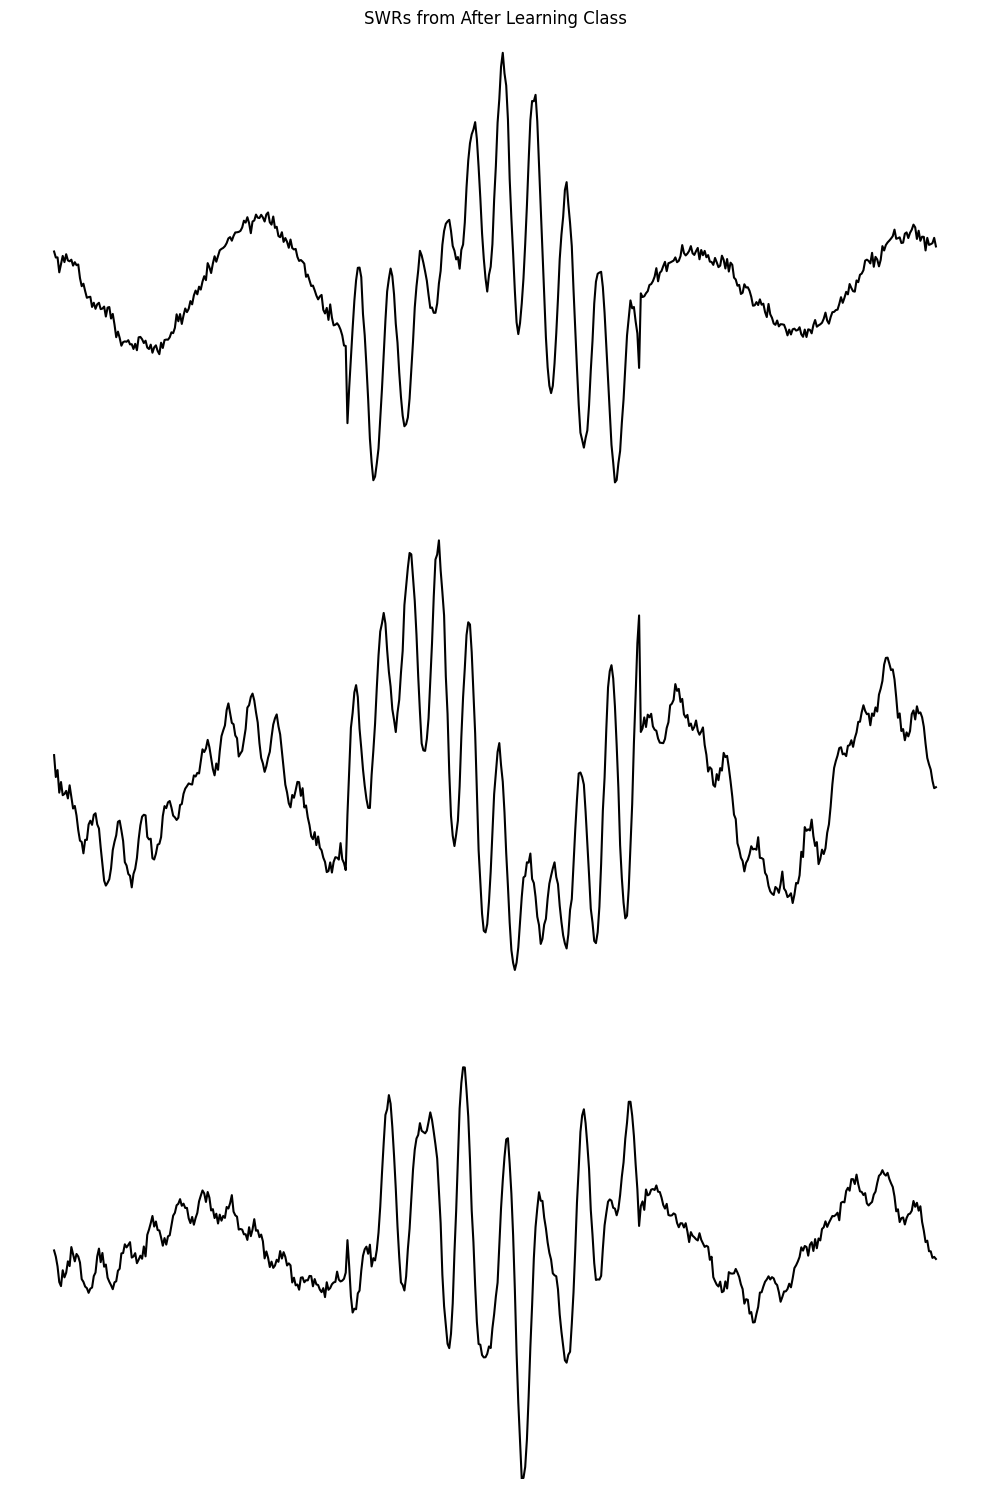

In [60]:
plot_random_swrs(after_learning_dataset, n_samples=3, title="SWRs from After Learning Class")

In [4]:
# Combine the datasets
dataset = pd.concat([before_learning_dataset, after_learning_dataset])

In [5]:
dataset

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
0,-0.221663,-0.257189,-0.226410,-0.200494,-0.206597,-0.264861,-0.256260,-0.290253,-0.341663,-0.333906,...,-0.187295,-0.193329,-0.157222,-0.171323,-0.150266,-0.158458,-0.142318,-0.154892,-0.172152,0
1,0.221253,0.169868,0.107371,0.083876,0.094189,0.110245,0.110063,0.087971,0.131723,0.137032,...,0.182281,0.152978,0.120832,0.102274,0.148275,0.150225,0.201356,0.229329,0.262688,0
2,-0.254372,-0.224552,-0.250716,-0.172196,-0.151516,-0.164874,-0.127033,-0.149887,-0.155268,-0.145767,...,-0.229302,-0.213873,-0.194484,-0.189477,-0.202056,-0.216224,-0.199270,-0.212966,-0.210031,0
3,0.340715,0.309102,0.261813,0.264695,0.208874,0.210899,0.206445,0.222443,0.201492,0.193159,...,0.196245,0.207222,0.182171,0.159018,0.141662,0.161731,0.178677,0.197675,0.184468,0
4,-0.390611,-0.358315,-0.344031,-0.344332,-0.275773,-0.336006,-0.336491,-0.314758,-0.283268,-0.206212,...,-0.402762,-0.358529,-0.380538,-0.366474,-0.355857,-0.335963,-0.313833,-0.275450,-0.258864,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.007922,-0.007090,-0.009406,-0.022378,-0.043659,-0.054574,-0.040846,-0.065563,-0.052467,-0.050383,...,0.124913,0.106546,0.045379,0.023516,-0.012691,-0.012868,-0.031635,-0.013672,-0.004504,1
9996,0.072947,0.055299,0.015412,-0.002870,-0.031662,-0.057600,-0.079149,-0.076902,-0.113935,-0.120203,...,0.015691,0.037052,-0.001207,0.012586,0.002149,0.030420,0.017667,0.023868,0.018007,1
9997,-0.202807,-0.192853,-0.147512,-0.102406,-0.084523,-0.062348,-0.033821,-0.019454,-0.028331,-0.040883,...,-0.101160,-0.102931,-0.123669,-0.112790,-0.145081,-0.152584,-0.208129,-0.191380,-0.178109,1
9998,-0.070588,-0.080587,-0.114830,-0.111613,-0.144817,-0.179265,-0.079389,-0.106352,-0.061470,-0.021295,...,-0.223879,-0.169348,-0.158883,-0.180129,-0.129922,-0.115087,-0.135750,-0.132959,-0.115486,1


# Supervised learning using our custom 1D CNN

In [102]:
# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [103]:
# Prepare data loaders
train_loader, val_loader = prepare_data(dataset, batch_size=BATCH_SIZE, train_split=0.8)

In [104]:
# Initialize model
model = CNN1D(input_size=512, num_classes=2)

In [105]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [106]:
# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, 
                     num_epochs=NUM_EPOCHS, device=DEVICE)

Training Progress: 100%|█| 100/100 [01:26<00:00,  1.16it/s, train_loss=0.0137, train_acc=0.9949, train_f1=0.9949, val_loss=0.8556, val_acc=0.8512, val


Training completed! Best model saved at epoch 14
Best validation Accuracy: 0.8818
Best validation F1-score: 0.8844


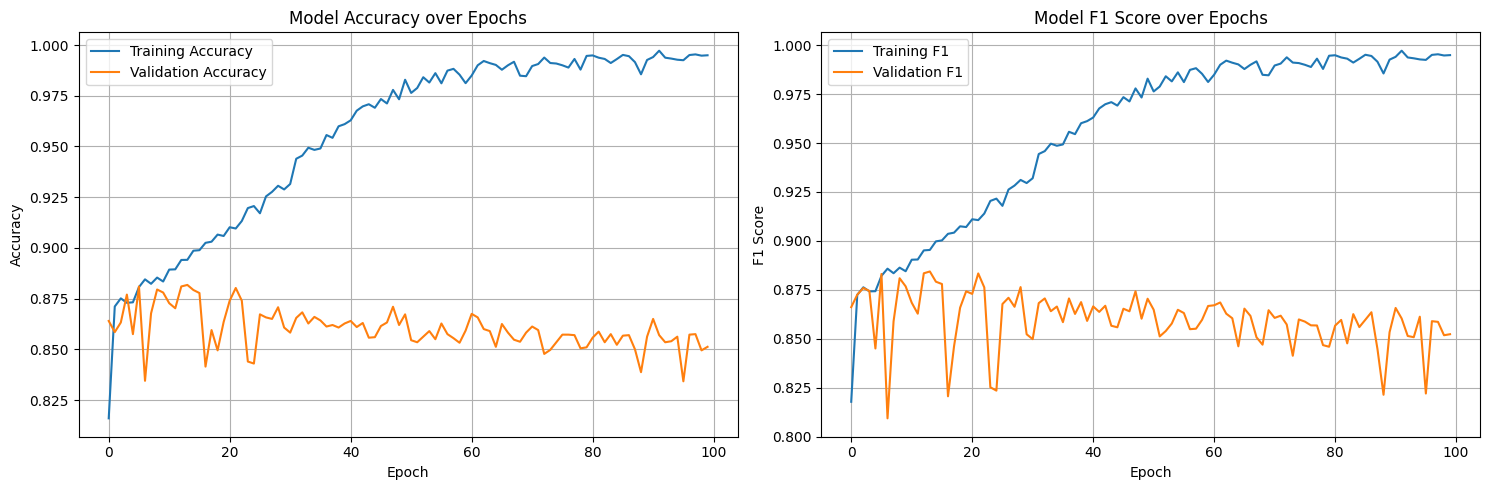

In [107]:
plot_training_history(history)


Training with 0% noise:
Requested noise ratio: 0.00%
Actual noise ratio: 0.00%
Number of flipped labels: 0

Class distribution:
Original:
label
0    0.5
1    0.5
Name: proportion, dtype: float64

Noisy:
label
0    0.5
1    0.5
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [01:53<00:00,  2.27s/it, train_loss=0.0299, train_acc=0.9882, train_f1=0.9882, val_loss=0.7631, val_acc=0.8638, val_f



Training completed! Best model saved at epoch 2
Best validation Accuracy: 0.8828
Best validation F1-score: 0.8875

Training with 10.0% noise:
Requested noise ratio: 10.00%
Actual noise ratio: 10.00%
Number of flipped labels: 2000

Class distribution:
Original:
label
0    0.5
1    0.5
Name: proportion, dtype: float64

Noisy:
label
1    0.5023
0    0.4977
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [01:54<00:00,  2.29s/it, train_loss=0.1336, train_acc=0.9387, train_f1=0.9405, val_loss=1.3007, val_acc=0.7308, val_f



Training completed! Best model saved at epoch 4
Best validation Accuracy: 0.8013
Best validation F1-score: 0.8094

Training with 20.0% noise:
Requested noise ratio: 20.00%
Actual noise ratio: 20.00%
Number of flipped labels: 4000

Class distribution:
Original:
label
0    0.5
1    0.5
Name: proportion, dtype: float64

Noisy:
label
1    0.5019
0    0.4981
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [01:55<00:00,  2.32s/it, train_loss=0.2082, train_acc=0.8991, train_f1=0.8962, val_loss=1.5126, val_acc=0.6558, val_f



Training completed! Best model saved at epoch 6
Best validation Accuracy: 0.7230
Best validation F1-score: 0.7333

Training with 30.0% noise:
Requested noise ratio: 30.00%
Actual noise ratio: 30.00%
Number of flipped labels: 6000

Class distribution:
Original:
label
0    0.5
1    0.5
Name: proportion, dtype: float64

Noisy:
label
1    0.5017
0    0.4983
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [01:54<00:00,  2.29s/it, train_loss=0.6932, train_acc=0.5053, train_f1=0.6714, val_loss=0.6936, val_acc=0.4873, val_f



Training completed! Best model saved at epoch 1
Best validation Accuracy: 0.4873
Best validation F1-score: 0.6552

Training with 40.0% noise:
Requested noise ratio: 40.00%
Actual noise ratio: 40.00%
Number of flipped labels: 8000

Class distribution:
Original:
label
0    0.5
1    0.5
Name: proportion, dtype: float64

Noisy:
label
1    0.5026
0    0.4974
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [01:55<00:00,  2.31s/it, train_loss=0.4755, train_acc=0.7748, train_f1=0.7500, val_loss=1.0123, val_acc=0.5327, val_f



Training completed! Best model saved at epoch 1
Best validation Accuracy: 0.5483
Best validation F1-score: 0.6131

Training with 50.0% noise:
Requested noise ratio: 50.00%
Actual noise ratio: 50.00%
Number of flipped labels: 10000

Class distribution:
Original:
label
0    0.5
1    0.5
Name: proportion, dtype: float64

Noisy:
label
1    0.5034
0    0.4966
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [01:54<00:00,  2.30s/it, train_loss=0.6931, train_acc=0.5058, train_f1=0.6718, val_loss=0.6934, val_acc=0.4940, val_f



Training completed! Best model saved at epoch 1
Best validation Accuracy: 0.4948
Best validation F1-score: 0.6616


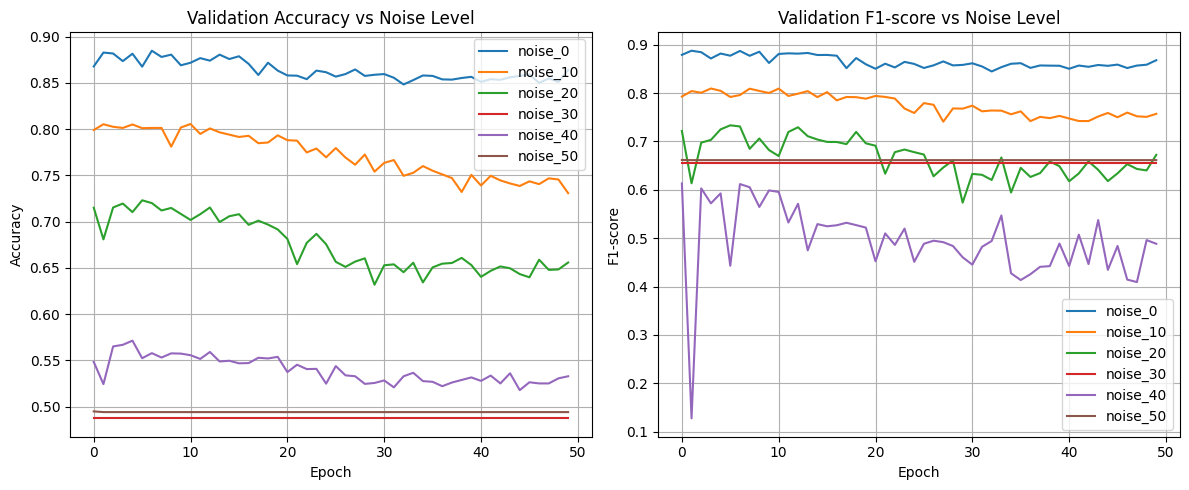

In [77]:
# Create datasets with different noise levels
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]  # Example: 10%, 20%, 30% noise
results = {}

for noise_level in noise_levels:
    print(f"\nTraining with {noise_level*100}% noise:")
    
    # Add noise to labels
    noisy_data = add_label_noise(dataset, noise_ratio=noise_level)
    
    # Prepare data
    train_loader, val_loader = prepare_data(noisy_data)
    
    # Train model
    model = CNN1D(input_size=noisy_data.shape[1]-1, num_classes=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    history = train_model(model, train_loader, val_loader, criterion, optimizer)
    
    # Store results
    results[f"noise_{int(noise_level*100)}"] = history

# Plot results for different noise levels
plt.figure(figsize=(12, 5))

# Plot validation accuracy for different noise levels
plt.subplot(1, 2, 1)
for noise_level in results:
    plt.plot(results[noise_level]['val_acc'], label=f'{noise_level}')
plt.title('Validation Accuracy vs Noise Level')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot validation F1 for different noise levels
plt.subplot(1, 2, 2)
for noise_level in results:
    plt.plot(results[noise_level]['val_f1'], label=f'{noise_level}')
plt.title('Validation F1-score vs Noise Level')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Self Supervised Learning

In [8]:
# Config class for hyperparameters
class Config:
    def __init__(self):
        # Model configs
        self.input_channels = 1
        self.kernel_size = 8
        self.stride = 1
        self.final_out_channels = 128
        self.features_len = 66
        self.num_classes = 2
        self.dropout = 0.35
        
        # Training configs
        self.batch_size = 128
        self.num_epochs = 100
        self.learning_rate = 3e-4
        
        # Augmentation configs
        self.jitter_scale_ratio = 0.001
        self.jitter_ratio = 0.001
        self.max_seg = 12

        # TC (Temporal Contrasting) configs
        self.TC_hidden_dim = 100
        self.TC_timesteps = 10

        # Context Contrastive configs
        self.temperature = 0.2
        self.use_cosine_similarity = True

In [9]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize config
config = Config()

# Prepare data loaders
dataset = add_label_noise(dataset, noise_ratio=0.2) # we created a 20% label noise dataset
train_loader, val_loader, test_loader = prepare_ssl_data(dataset, config)

# Initialize model
encoder = Encoder(config).to(device)
temporal_contr_model = TC(config, device).to(device)

# Train model
encoder = train_self_supervised(encoder, temporal_contr_model, train_loader, config, device)

Requested noise ratio: 20.00%
Actual noise ratio: 20.00%
Number of flipped labels: 4000

Class distribution:
Original:
label
1    0.5019
0    0.4981
Name: proportion, dtype: float64

Noisy:
label
0    0.5
1    0.5
Name: proportion, dtype: float64


C:\projects\ts-ssl-label-noise\.venv\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/100], Loss: 13.1514
Epoch [2/100], Loss: 12.2715
Epoch [3/100], Loss: 11.8212
Epoch [4/100], Loss: 11.5149
Epoch [5/100], Loss: 11.2232
Epoch [6/100], Loss: 11.1261
Epoch [7/100], Loss: 10.6765
Epoch [8/100], Loss: 10.5473
Epoch [9/100], Loss: 10.5674
Epoch [10/100], Loss: 10.4454
Epoch [11/100], Loss: 10.5749
Epoch [12/100], Loss: 10.3011
Epoch [13/100], Loss: 10.2309
Epoch [14/100], Loss: 10.3274
Epoch [15/100], Loss: 10.1774
Epoch [16/100], Loss: 10.1944
Epoch [17/100], Loss: 9.8004
Epoch [18/100], Loss: 10.0088
Epoch [19/100], Loss: 10.0466
Epoch [20/100], Loss: 9.9425
Epoch [21/100], Loss: 10.1051
Epoch [22/100], Loss: 10.0381
Epoch [23/100], Loss: 9.8480
Epoch [24/100], Loss: 9.7298
Epoch [25/100], Loss: 9.8849
Epoch [26/100], Loss: 9.8212
Epoch [27/100], Loss: 9.7274
Epoch [28/100], Loss: 9.8337
Epoch [29/100], Loss: 9.7457
Epoch [30/100], Loss: 9.8311
Epoch [31/100], Loss: 9.7081
Epoch [32/100], Loss: 9.6404
Epoch [33/100], Loss: 9.5805
Epoch [34/100], Loss: 9.5271
Epo

# Relabeling

In [10]:
relabeled_dataset = relabel_dataset(encoder, dataset, config, device)
relabeled_dataset

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
0,-0.221663,-0.257189,-0.226410,-0.200494,-0.206597,-0.264861,-0.256260,-0.290253,-0.341663,-0.333906,...,-0.187295,-0.193329,-0.157222,-0.171323,-0.150266,-0.158458,-0.142318,-0.154892,-0.172152,0
1,0.221253,0.169868,0.107371,0.083876,0.094189,0.110245,0.110063,0.087971,0.131723,0.137032,...,0.182281,0.152978,0.120832,0.102274,0.148275,0.150225,0.201356,0.229329,0.262688,0
2,-0.254372,-0.224552,-0.250716,-0.172196,-0.151516,-0.164874,-0.127033,-0.149887,-0.155268,-0.145767,...,-0.229302,-0.213873,-0.194484,-0.189477,-0.202056,-0.216224,-0.199270,-0.212966,-0.210031,0
3,0.340715,0.309102,0.261813,0.264695,0.208874,0.210899,0.206445,0.222443,0.201492,0.193159,...,0.196245,0.207222,0.182171,0.159018,0.141662,0.161731,0.178677,0.197675,0.184468,1
4,-0.390611,-0.358315,-0.344031,-0.344332,-0.275773,-0.336006,-0.336491,-0.314758,-0.283268,-0.206212,...,-0.402762,-0.358529,-0.380538,-0.366474,-0.355857,-0.335963,-0.313833,-0.275450,-0.258864,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.007922,-0.007090,-0.009406,-0.022378,-0.043659,-0.054574,-0.040846,-0.065563,-0.052467,-0.050383,...,0.124913,0.106546,0.045379,0.023516,-0.012691,-0.012868,-0.031635,-0.013672,-0.004504,1
9996,0.072947,0.055299,0.015412,-0.002870,-0.031662,-0.057600,-0.079149,-0.076902,-0.113935,-0.120203,...,0.015691,0.037052,-0.001207,0.012586,0.002149,0.030420,0.017667,0.023868,0.018007,0
9997,-0.202807,-0.192853,-0.147512,-0.102406,-0.084523,-0.062348,-0.033821,-0.019454,-0.028331,-0.040883,...,-0.101160,-0.102931,-0.123669,-0.112790,-0.145081,-0.152584,-0.208129,-0.191380,-0.178109,0
9998,-0.070588,-0.080587,-0.114830,-0.111613,-0.144817,-0.179265,-0.079389,-0.106352,-0.061470,-0.021295,...,-0.223879,-0.169348,-0.158883,-0.180129,-0.129922,-0.115087,-0.135750,-0.132959,-0.115486,0


In [108]:
train_loader, val_loader = prepare_data(relabeled_dataset, batch_size=BATCH_SIZE, train_split=0.8)

In [109]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, 
                     num_epochs=NUM_EPOCHS, device=DEVICE)

Training Progress: 100%|█| 100/100 [01:35<00:00,  1.05it/s, train_loss=0.0139, train_acc=0.9944, train_f1=0.9959, val_loss=0.1834, val_acc=0.9470, val


Training completed! Best model saved at epoch 23
Best validation Accuracy: 0.9728
Best validation F1-score: 0.9801


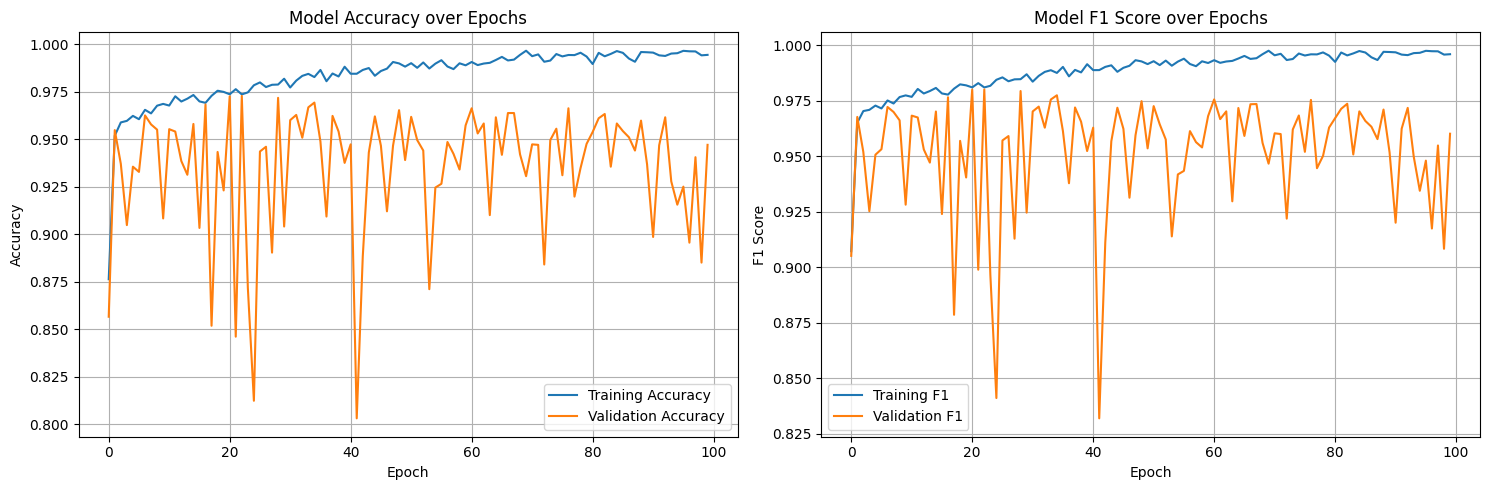

In [110]:
plot_training_history(history)